In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from idealista.resources.automate_ploting import (plot_continuous_dist, 
                                                  plot_continuous_dist, 
                                                  compare_dist)
from idealista.resources.find_best_fit import (find_best_dist, calculate_pdf, 
                                               calculate_edf, find_best_fit_based_ks,
                                               calculate_cdf)

In [2]:
plt.style.use('seaborn')
colors = sns.color_palette('colorblind')
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [3]:
type(colors)

seaborn.palettes._ColorPalette

## Load data houses_Madrid.csv from kaggle

In [4]:
df = pd.read_csv('data/houses_Madrid.csv', index_col=[0])
df.shape

(21742, 57)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21742 entries, 0 to 21741
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            21742 non-null  int64  
 1   title                         21742 non-null  object 
 2   subtitle                      21742 non-null  object 
 3   sq_mt_built                   21616 non-null  float64
 4   sq_mt_useful                  8228 non-null   float64
 5   n_rooms                       21742 non-null  int64  
 6   n_bathrooms                   21726 non-null  float64
 7   n_floors                      1437 non-null   float64
 8   sq_mt_allotment               1432 non-null   float64
 9   latitude                      0 non-null      float64
 10  longitude                     0 non-null      float64
 11  raw_address                   16277 non-null  object 
 12  is_exact_address_hidden       21742 non-null  bool   
 13  s

### Purpose of the data:

In [6]:
(df.loc[:, 'operation'].unique(), 
 df.loc[:, 'is_buy_price_known'].unique(), 
 df.loc[:, 'is_rent_price_known'].unique(),
 df.loc[:, 'house_type_id'].unique(), )

(array(['sale'], dtype=object),
 array([ True]),
 array([False]),
 array(['HouseType 1: Pisos', 'HouseType 4: Dúplex', nan,
        'HouseType 5: Áticos', 'HouseType 2: Casa o chalet'], dtype=object))

It's easy to see that the data source is a website like idealista. 
Also, it can be confirmed that all properties in the dataset are for sale, 
and there are 4 types of real-estate product.

For the first part of the analysis, there going to be picked the following features:
- sq_mt_built
- n_rooms
- n_bathrooms
- raw_address, and also title and subtitle for NPL
- is_exact_address_hidden
- neighborhood_id
- house_type_id
- built_year

In [7]:
features_selected = ['title','subtitle','sq_mt_built','n_rooms','n_bathrooms',
                     'raw_address','is_exact_address_hidden','neighborhood_id',
                     'house_type_id','built_year', 'buy_price']
new_df = df.loc[:, features_selected]
new_df.describe()

,sq_mt_built,n_rooms,n_bathrooms,built_year,buy_price
count,21616.000000,21742.000000,21726.000000,10000.000000,2.174200e+04
mean,146.920892,3.005749,2.091687,1970.046400,6.537356e+05
std,134.181865,1.510497,1.406992,69.386705,7.820821e+05
min,13.000000,0.000000,1.000000,1723.000000,3.600000e+04
25%,70.000000,2.000000,1.000000,1957.000000,1.980000e+05
50%,100.000000,3.000000,2.000000,1970.000000,3.750000e+05
75%,162.000000,4.000000,2.000000,1994.000000,7.636000e+05
max,999.000000,24.000000,16.000000,8170.000000,8.800000e+06


Now, it much easier to search for the null values present in the dataset and their proportion.
It easey to observe that there are two features that contain missing values.
1. built_year has more than the 50% of the observation missing, and
2. raw_address has more than the 25% of the records null.

In [8]:
new_df.isnull().sum().sort_values(ascending=False)

built_year                 11742
raw_address                 5465
house_type_id                391
sq_mt_built                  126
n_bathrooms                   16
title                          0
subtitle                       0
n_rooms                        0
is_exact_address_hidden        0
neighborhood_id                0
buy_price                      0
dtype: int64

In [9]:
# proportion in percentage
new_df.isnull().sum().sort_values(ascending=False) / new_df.shape[0] * 100

built_year                 54.006071
raw_address                25.135682
house_type_id               1.798363
sq_mt_built                 0.579524
n_bathrooms                 0.073590
title                       0.000000
subtitle                    0.000000
n_rooms                     0.000000
is_exact_address_hidden     0.000000
neighborhood_id             0.000000
buy_price                   0.000000
dtype: float64

Additionally, it can be noted that there are 126 different neighborhood_ids

In [10]:
len(new_df['neighborhood_id'].unique())

126

So, let's first explore these features separately one by one, and then explore if there is any pattern or relation between them.

## 1. Square Meter Built

In [11]:
sq_mt_built = new_df.loc[:,'sq_mt_built']
sq_mt_built.describe()

count    21616.000000
mean       146.920892
std        134.181865
min         13.000000
25%         70.000000
50%        100.000000
75%        162.000000
max        999.000000
Name: sq_mt_built, dtype: float64

In [12]:
sq_mt_built.dropna(inplace=True)
sq_mt_built.isnull().sum()

0

`plot_distribution` is a handly function that can help and automate the distribution visualizations of the features,
in this case, the property square meter built containing in the dataset.

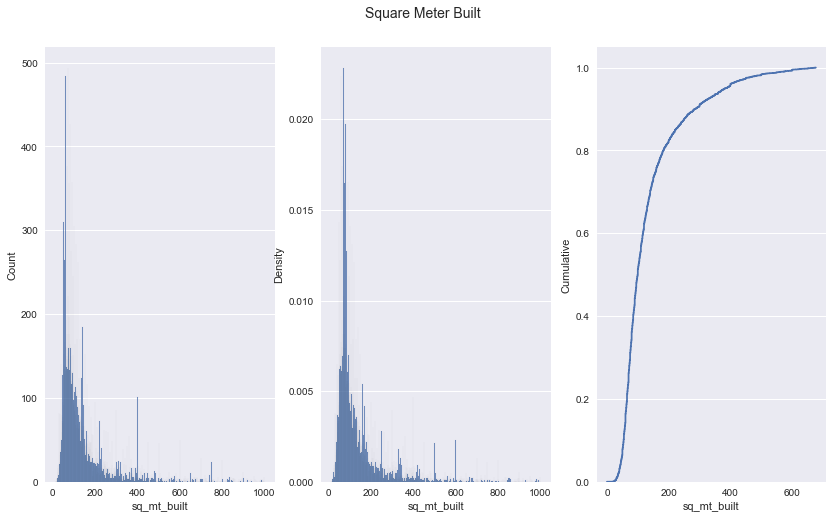

In [13]:
plot_continuous_dist(sq_mt_built, 'Square Meter Built')

Let's discover if there is a statistical distribution that "sq_mt_built" can fit with.

`fin_best_fit_based_ks` is a function based on Kolmogorov-Smirnov statistical test. It uses scipy package to perform the calculations and estimations to figure out what is the distibution that best fit with the data input, in this case with sq_mt_built.

Its output is a map that contain valuable info related to the K-S test:

`{
    'distribution': 
    'd_statistic': 
    'p_value': 
    'params':
 }
 `

In [14]:
test_results = find_best_fit_based_ks(sq_mt_built.values)
test_results

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': 'johnsonsu',
 'd_statistic': 0.01863349802308778,
 'p_value': 5.973609620605609e-07,
 'params': (-1.7466824060289992,
  0.914051559872858,
  44.55522615905206,
  17.261716167682188)}

Additionally to `find_best_fit_based_ks`, `find_best_dist` helps also to find the best fit distribution for the data observed but based on manually calculating the error between the observations and the distribution evaluated. Two posible ways of perform these computation have been taking into account:
1. "the squared estimate of errors" or sse
2. "the max error present" or max_err

In [15]:
test_results_2 = find_best_dist(sq_mt_built.values, err_type='sse')
test_results_2

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': 'kappa3',
 'error': 1.2790142686257657e-07,
 'params': (2.621521030957539, 12.999999999995094, 117.6460924119489)}

In [16]:
test_results_3 = find_best_dist(sq_mt_built.values, err_type='max_err')
test_results_3

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': 'kappa3',
 'error': 0.00020950402731575969,
 'params': (2.621521030957539, 12.999999999995094, 117.6460924119489)}

In [24]:
x_sorted = sq_mt_built.sort_values().values
pdf_x, pdf_y = calculate_pdf(distribution_name=test_results['distribution'],
                             params=test_results['params'],
                             size=sq_mt_built.shape[0])
edf = calculate_edf(data=sq_mt_built.values)
cdf = calculate_cdf(data=x_sorted, 
                    distribution_name=test_results['distribution'], 
                    params=test_results['params'])
pdf = pd.Series(pdf_x, pdf_y)

The following graph shows the best theoretical distribution found against the actual observations, which it helps to roughly see how similar they are.

Visually, it can be noted that they approximately overlap. However, some indicators such as the p_value and R^2, which are provided by `find_best_fit_based_ks` and `stats.probplot` respectively, can be more informative, so let's review them!
1. test 1:
    - p_value = 5.973609620605609e-07 < 0.05. Theoretically, if p < 0.05 it can be infered that the observations don't fit the best distribution found.
    - d_statistic = 0.01863349802308778
    - R^2 = 0.8811, which means that just about the 88% of the observation can be modeled through the distribution found
    
2. test 2:
    - sse = 1.2790142686257657e-07
    - R^2 = 0.8310

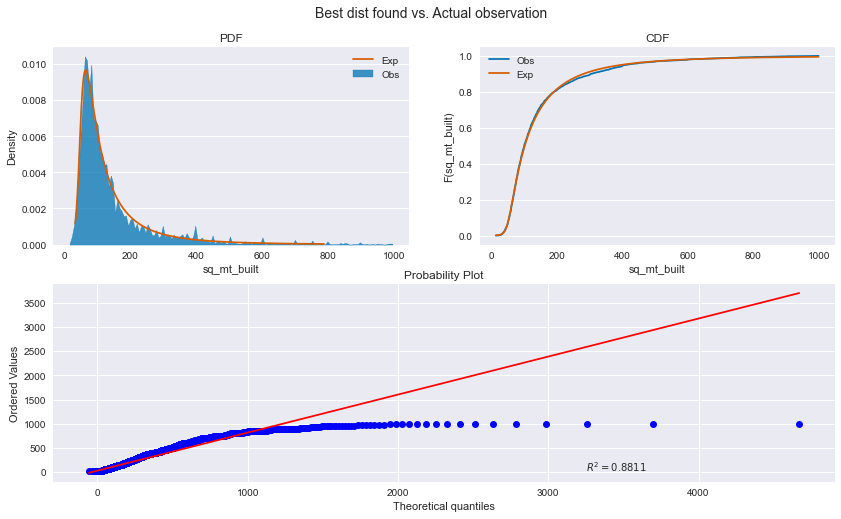

In [25]:
_ = plt.figure(figsize=(14,8))
plt.suptitle('Best dist found vs. Actual observation', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')

plt.subplot(2,2,1)
sns.histplot(sq_mt_built, stat='density', discrete=False, 
             element='poly', label='Obs', color=colors[0])
sns.lineplot(x=pdf_x, y=pdf_y, label='Exp', color=colors[3])
plt.title('PDF')
plt.grid(False, axis='x')
plt.legend()

plt.subplot(2,2,2)
sns.lineplot(x=x_sorted, y=edf, label='Obs', color=colors[0]) # --> linewidth=4
sns.lineplot(x=x_sorted, y=cdf, label='Exp', color=colors[3])
plt.title('CDF')
plt.xlabel('sq_mt_built')
plt.ylabel('F(sq_mt_built)')
plt.grid(False, axis='x')
plt.legend()

plt.subplot(2,1,2)
a, b = stats.probplot(sq_mt_built, 
                      sparams=test_results['params'],
                      dist=test_results['distribution'],
                      fit=True, plot=plt, rvalue=True)

In [26]:
x_sorted = sq_mt_built.sort_values().values
pdf_x, pdf_y = calculate_pdf(distribution_name=test_results_2['distribution'],
                             params=test_results_2['params'],
                             size=sq_mt_built.shape[0])
edf = calculate_edf(data=sq_mt_built.values)
cdf = calculate_cdf(data=x_sorted, 
                    distribution_name=test_results_2['distribution'], 
                    params=test_results_2['params'])
pdf = pd.Series(pdf_x, pdf_y)

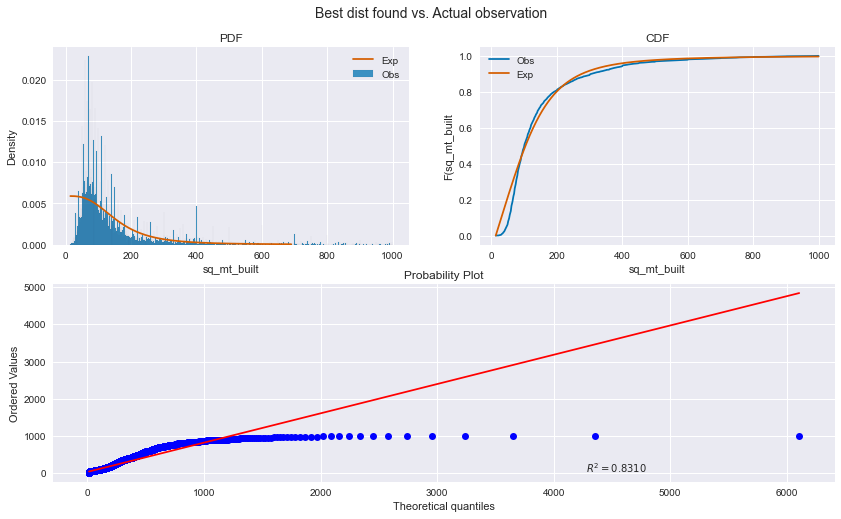

In [27]:
_ = plt.figure(figsize=(14,8))
feature_name = 'sq_mt_built'
plt.suptitle('Best dist found vs. Actual observation', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')

plt.subplot(2,2,1)
sns.histplot(sq_mt_built, stat='density', discrete=True, 
             element='bars', label='Obs', color=colors[0])
sns.lineplot(x=pdf_x, y=pdf_y, label='Exp', color=colors[3])
plt.title('PDF')
plt.legend()

plt.subplot(2,2,2)
sns.lineplot(x=x_sorted, y=edf, label='Obs', color=colors[0])
sns.lineplot(x=x_sorted, y=cdf, label='Exp', color=colors[3])
plt.title('CDF')
plt.xlabel(feature_name)
plt.ylabel(f'F({feature_name}')
plt.legend()

plt.subplot(2,1,2)
a, b = stats.probplot(sq_mt_built, 
                      sparams=test_results_2['params'],
                      dist=test_results_2['distribution'],
                      fit=True, plot=plt, rvalue=True)

## 2. Number of rooms

In [28]:
n_rooms = new_df.loc[:, 'n_rooms']
n_rooms.describe()

count    21742.000000
mean         3.005749
std          1.510497
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         24.000000
Name: n_rooms, dtype: float64

Is there any null value in this feature? --> There is no null value, as it can be seen below.

In [29]:
n_rooms.isnull().sum()

0

Now, let's explore how looks its distribution

In [30]:
x = n_rooms.value_counts().sort_index().index
y = n_rooms.value_counts().sort_index().values

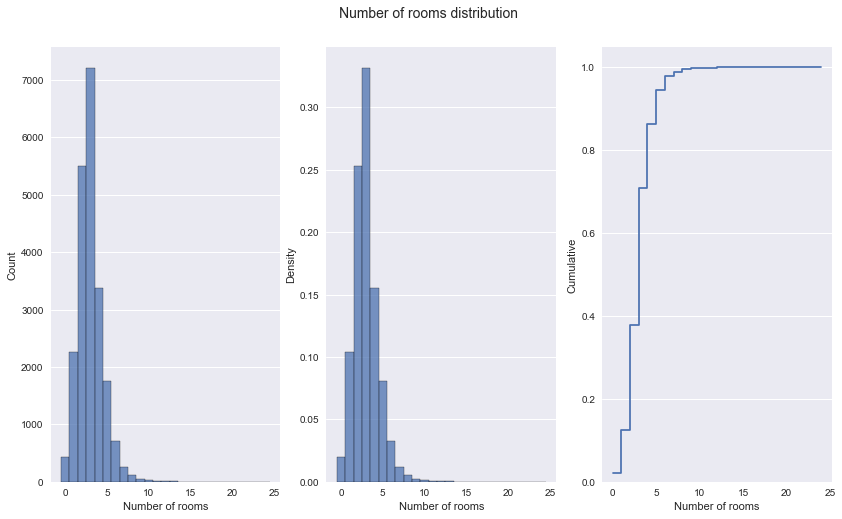

In [31]:
_ = plt.figure(figsize=(14,8))
plt.suptitle('Number of rooms distribution', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')
bins=range(0,25,1) # bins for categorical features, room can take values between 0 and 25 (int)

plt.subplot(1,3,1)
sns.histplot(x=n_rooms, bins=bins, stat='count', discrete=True, 
             element='bars', cumulative=False, fill=True)
plt.xlabel('Number of rooms')
plt.ylabel('Count')
plt.grid(False, axis='x')

plt.subplot(1,3,2)
sns.histplot(x=n_rooms, bins=bins, stat='density', discrete=True, 
             element='bars', cumulative=False, fill=True)
plt.xlabel('Number of rooms')
plt.grid(False, axis='x')

plt.subplot(1,3,3)
sns.histplot(x=n_rooms, bins=bins, stat='probability', discrete=False, 
             element='step', cumulative=True, fill=False)
plt.xlabel('Number of rooms')
plt.ylabel('Cumulative')
plt.grid(False, axis='x')

In [32]:
test_results = find_best_fit_based_ks(n_rooms.values)
test_results

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': None, 'd_statistic': 1, 'p_value': 0, 'params': None}

In [34]:
test_results_2 = find_best_dist(n_rooms, err_type='sse')
test_results_2

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': 'genextreme',
 'error': 0.00022971539434522148,
 'params': (0.03970181449610216, 2.3478527602232573, 1.2592011619517502)}

In [35]:
test_results_3 = find_best_dist(n_rooms, err_type='max_err')
test_results_3

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': 'burr',
 'error': 0.012207812174555785,
 'params': (785.3814634494588,
  1223.3321842970172,
  -980.5095295685915,
  973.9739767654628)}

In [36]:
x_sorted = n_rooms.sort_values().values
pdf_x, pdf_y = calculate_pdf(distribution_name=test_results_2['distribution'],
                             params=test_results_2['params'],
                             size=n_rooms.shape[0])
edf = calculate_edf(data=n_rooms.values)
cdf = calculate_cdf(data=x_sorted, 
                    distribution_name=test_results_2['distribution'], 
                    params=test_results_2['params'])
pdf = pd.Series(pdf_x, pdf_y)

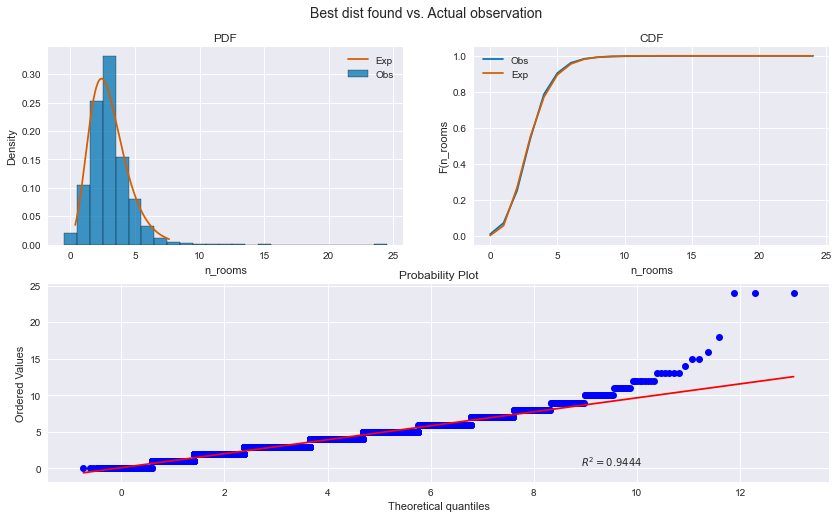

In [37]:
_ = plt.figure(figsize=(14,8))
feature_name = 'n_rooms'
plt.suptitle('Best dist found vs. Actual observation', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')

plt.subplot(2,2,1)
sns.histplot(n_rooms, stat='density', discrete=True, 
             element='bars', label='Obs', color=colors[0])
sns.lineplot(x=pdf_x, y=pdf_y, label='Exp', color=colors[3])
plt.title('PDF')
plt.legend()

plt.subplot(2,2,2)
sns.lineplot(x=x_sorted, y=edf, label='Obs', color=colors[0]) # --> linewidth=4
sns.lineplot(x=x_sorted, y=cdf, label='Exp', color=colors[3])
plt.title('CDF')
plt.xlabel(feature_name)
plt.ylabel(f'F({feature_name}')
plt.legend()

plt.subplot(2,1,2)
a, b = stats.probplot(n_rooms, 
                      sparams=test_results_2['params'],
                      dist=test_results_2['distribution'],
                      fit=True, plot=plt, rvalue=True)

In [38]:
x_sorted = n_rooms.sort_values().values
pdf_x, pdf_y = calculate_pdf(distribution_name=test_results_3['distribution'],
                             params=test_results_3['params'],
                             size=n_rooms.shape[0])
edf = calculate_edf(data=n_rooms.values)
cdf = calculate_cdf(data=x_sorted, 
                    distribution_name=test_results_3['distribution'], 
                    params=test_results_3['params'])
pdf = pd.Series(pdf_x, pdf_y)

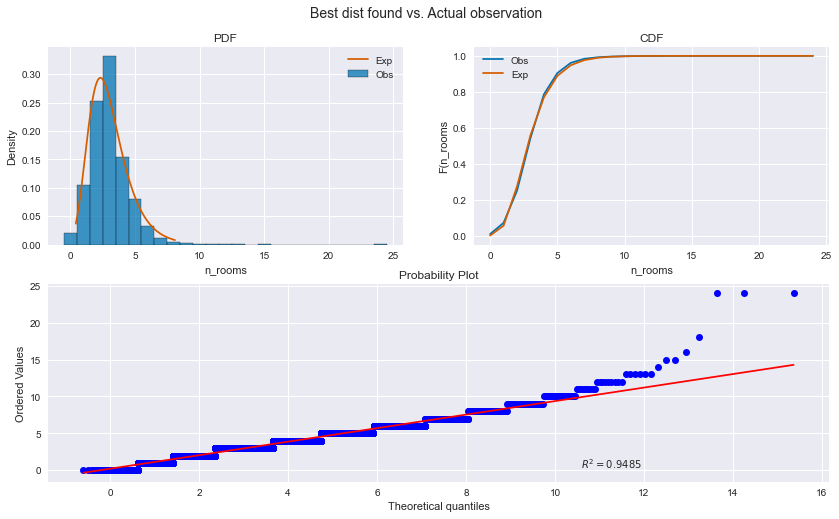

In [39]:
_ = plt.figure(figsize=(14,8))
feature_name = 'n_rooms'
plt.suptitle('Best dist found vs. Actual observation', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')

plt.subplot(2,2,1)
sns.histplot(n_rooms, stat='density', discrete=True, 
             element='bars', label='Obs', color=colors[0])
sns.lineplot(x=pdf_x, y=pdf_y, label='Exp', color=colors[3])
plt.title('PDF')
plt.legend()

plt.subplot(2,2,2)
sns.lineplot(x=x_sorted, y=edf, label='Obs', color=colors[0]) # --> linewidth=4
sns.lineplot(x=x_sorted, y=cdf, label='Exp', color=colors[3])
plt.title('CDF')
plt.xlabel(feature_name)
plt.ylabel(f'F({feature_name}')
plt.legend()

plt.subplot(2,1,2)
a, b = stats.probplot(n_rooms, 
                      sparams=test_results_3['params'],
                      dist=test_results_3['distribution'],
                      fit=True, plot=plt, rvalue=True)

## 3. Number of Bathrooms

In [40]:
n_bathrooms = new_df.loc[:, 'n_bathrooms']

(n_bathrooms.isnull().sum(), 
 n_bathrooms.describe())

(16,
 count    21726.000000
 mean         2.091687
 std          1.406992
 min          1.000000
 25%          1.000000
 50%          2.000000
 75%          2.000000
 max         16.000000
 Name: n_bathrooms, dtype: float64)

In [41]:
n_bathrooms.dropna(inplace=True)
n_bathrooms.isnull().sum()

0

In [42]:
n_bathrooms = n_bathrooms.astype('int32')
n_bathrooms.value_counts()

1     9084
2     7408
3     2429
4     1170
5      871
6      422
7      182
8       94
9       37
10      13
11       7
13       3
14       3
16       1
12       1
15       1
Name: n_bathrooms, dtype: int64

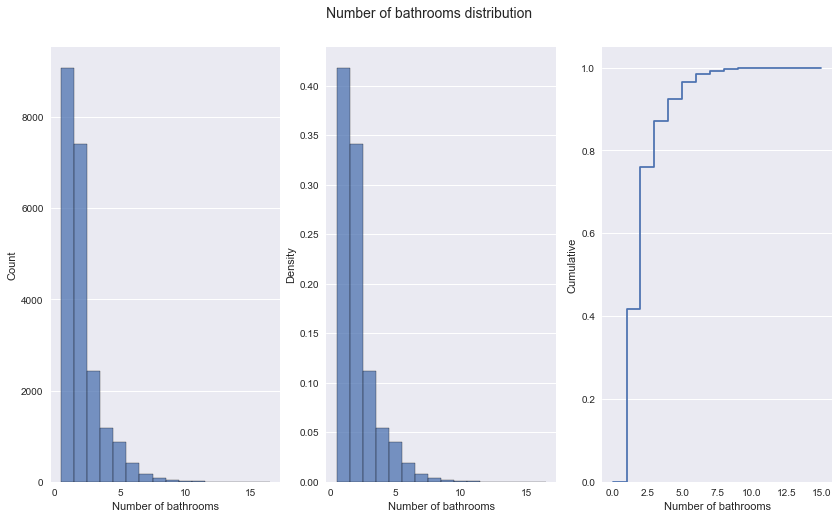

In [43]:
_ = plt.figure(figsize=(14,8))
plt.suptitle('Number of bathrooms distribution', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')
bins=range(0,16,1) # bins for categorical features, room can take values between 0 and 16 (int)

plt.subplot(1,3,1)
sns.histplot(x=n_bathrooms, bins=bins, stat='count', discrete=True, 
             element='bars', cumulative=False, fill=True)
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')
plt.grid(False, axis='x')

plt.subplot(1,3,2)
sns.histplot(x=n_bathrooms, bins=bins, stat='density', discrete=True, 
             element='bars', cumulative=False, fill=True)
plt.xlabel('Number of bathrooms')
plt.grid(False, axis='x')

plt.subplot(1,3,3)
sns.histplot(x=n_bathrooms, bins=bins, stat='probability', discrete=False, 
             element='step', cumulative=True, fill=False)
plt.xlabel('Number of bathrooms')
plt.ylabel('Cumulative')
plt.grid(False, axis='x')

In [44]:
test_results = find_best_fit_based_ks(n_bathrooms.values)
test_results

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': None, 'd_statistic': 1, 'p_value': 0, 'params': None}

In [45]:
test_results_2 = find_best_dist(n_bathrooms.values, err_type='sse')
test_results_2

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': 'cauchy',
 'error': 0.002350016974238249,
 'params': (1.664628886559511, 0.648140310613963)}

In [46]:
test_results_3 = find_best_dist(n_bathrooms.values, err_type='max_err')
test_results_3

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': 'loglaplace',
 'error': 0.04181025077288275,
 'params': (2.2230994244506626, -0.0087011932998243, 2.0087011906844126)}

In [47]:
x_sorted = n_bathrooms.sort_values().values
pdf_x, pdf_y = calculate_pdf(distribution_name=test_results_2['distribution'],
                             params=test_results_2['params'],
                             size=n_bathrooms.shape[0])
edf = calculate_edf(data=n_bathrooms.values)
cdf = calculate_cdf(data=x_sorted, 
                    distribution_name=test_results_2['distribution'], 
                    params=test_results_2['params'])
pdf = pd.Series(pdf_x, pdf_y)

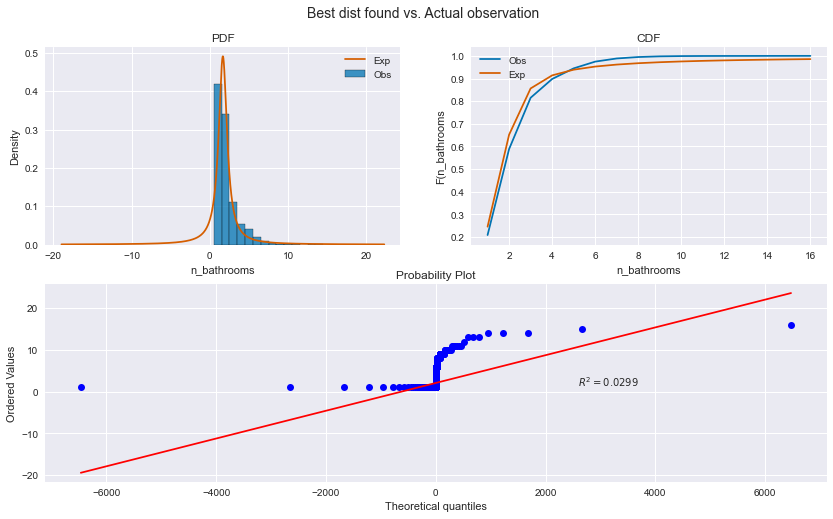

In [48]:
_ = plt.figure(figsize=(14,8))
feature_name = 'n_bathrooms'
plt.suptitle('Best dist found vs. Actual observation', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')

plt.subplot(2,2,1)
sns.histplot(n_bathrooms, stat='density', discrete=True, 
             element='bars', label='Obs', color=colors[0])
sns.lineplot(x=pdf_x, y=pdf_y, label='Exp', color=colors[3])
plt.title('PDF')
plt.legend()

plt.subplot(2,2,2)
sns.lineplot(x=x_sorted, y=edf, label='Obs', color=colors[0]) # --> linewidth=4
sns.lineplot(x=x_sorted, y=cdf, label='Exp', color=colors[3])
plt.title('CDF')
plt.xlabel(feature_name)
plt.ylabel(f'F({feature_name}')
plt.legend()

plt.subplot(2,1,2)
a, b = stats.probplot(n_bathrooms, 
                      sparams=test_results_2['params'],
                      dist=test_results_2['distribution'],
                      fit=True, plot=plt, rvalue=True)

In [49]:
x_sorted = n_bathrooms.sort_values().values
pdf_x, pdf_y = calculate_pdf(distribution_name=test_results_3['distribution'],
                             params=test_results_3['params'],
                             size=n_bathrooms.shape[0])
edf = calculate_edf(data=n_bathrooms.values)
cdf = calculate_cdf(data=x_sorted, 
                    distribution_name=test_results_3['distribution'], 
                    params=test_results_3['params'])
pdf = pd.Series(pdf_x, pdf_y)

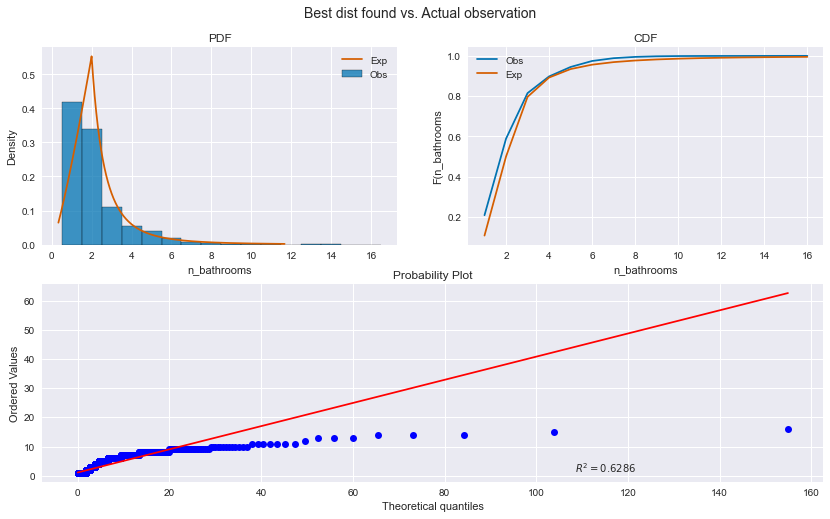

In [50]:
_ = plt.figure(figsize=(14,8))
feature_name = 'n_bathrooms'
plt.suptitle('Best dist found vs. Actual observation', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')

plt.subplot(2,2,1)
sns.histplot(n_bathrooms, stat='density', discrete=True, 
             element='bars', label='Obs', color=colors[0])
sns.lineplot(x=pdf_x, y=pdf_y, label='Exp', color=colors[3])
plt.title('PDF')
plt.legend()

plt.subplot(2,2,2)
sns.lineplot(x=x_sorted, y=edf, label='Obs', color=colors[0]) # --> linewidth=4
sns.lineplot(x=x_sorted, y=cdf, label='Exp', color=colors[3])
plt.title('CDF')
plt.xlabel(feature_name)
plt.ylabel(f'F({feature_name}')
plt.legend()

plt.subplot(2,1,2)
a, b = stats.probplot(n_bathrooms, 
                      sparams=test_results_3['params'],
                      dist=test_results_3['distribution'],
                      fit=True, plot=plt, rvalue=True)

## 4. Location

In [51]:
new_df.columns

Index(['title', 'subtitle', 'sq_mt_built', 'n_rooms', 'n_bathrooms',
       'raw_address', 'is_exact_address_hidden', 'neighborhood_id',
       'house_type_id', 'built_year', 'buy_price'],
      dtype='object')

## 5. Neighborhood

In [58]:
new_df.columns

Index(['title', 'subtitle', 'sq_mt_built', 'n_rooms', 'n_bathrooms',
       'raw_address', 'is_exact_address_hidden', 'neighborhood_id',
       'house_type_id', 'built_year', 'buy_price'],
      dtype='object')

In [59]:
neighborhood = new_df.neighborhood_id
neighborhood.isnull().sum(), neighborhood.describe()

(0,
 count                                                 21742
 unique                                                  126
 top       Neighborhood 23: Malasaña-Universidad (5196.25...
 freq                                                    485
 Name: neighborhood_id, dtype: object)

In [60]:
neighborhood.value_counts().describe()

count    126.000000
mean     172.555556
std      109.129688
min        2.000000
25%       91.000000
50%      152.500000
75%      234.000000
max      485.000000
Name: neighborhood_id, dtype: float64